In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # Progress bars

# Machine Learning Imports
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

# Deep Learning Imports
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 1. SETUP: LOAD YOUR DATABASE (THE RULE BOOK)
# Known additives.
my_file = '/content/drive/MyDrive/FOOD_ADDITIVE_LISTING_5.csv'
knowledge_base = {}
df_my = pd.DataFrame()

try:
    print("Loading rule book database...")
    df_my = pd.read_csv(my_file, encoding='latin-1')

    def clean_for_lookup(text):
        text = str(text).lower()
        text = re.sub(r'\(.*?\)', '', text)
        return text.replace('*', '').strip()

    for _, row in df_my.iterrows():
        status = row['status'].lower().strip()
        e_code = str(row['E-Code']).lower().strip()
        names = clean_for_lookup(row['Chemical Name']).split('/')
        knowledge_base[e_code] = status
        for n in names:
            if len(n) > 2: knowledge_base[n.strip()] = status

    print(f"Rule Book Loaded: {len(knowledge_base)} verified additives.")

    # Prepare DB data for training too
    df_my['text'] = df_my['Chemical Name'].astype(str) + " " + df_my['Description'].astype(str)
    df_my['label'] = df_my['status'].str.lower().str.strip()

    # Limit text length
    df_my['text'] = df_my['text'].str[:500]

except FileNotFoundError:
    print(f"Critical Error: Please upload '{my_file}'")

Loading rule book database...
✓ Rule Book Loaded: 692 verified additives.


In [ ]:
# 2. LOAD KAGGLE DATA

kaggle_file = '/content/drive/MyDrive/Ingredients.csv'
df_k = pd.DataFrame()

try:
    print("Loading Kaggle dataset...")
    df_k = pd.read_csv(kaggle_file)
    # Standardize columns
    if 'Ingredients' in df_k.columns:
        df_k = df_k.rename(columns={'Ingredients': 'text', 'Label': 'label'})
    elif 'text' not in df_k.columns:
        df_k = df_k.rename(columns={df_k.columns[0]: 'text', df_k.columns[1]: 'label'})

    df_k['text'] = df_k['text'].astype(str)
    df_k['label'] = df_k['label'].astype(str).str.lower().str.strip()

    # Normalize Labels (haram/non-halal -> doubtful)
    df_k['label'] = df_k['label'].replace({'non-halal': 'doubtful', 'haram': 'doubtful'})

    # Limit text length
    df_k['text'] = df_k['text'].str[:500]

    print(f"Kaggle Data Loaded: {len(df_k)} examples.")

except FileNotFoundError:
    print(f"Warning: Kaggle file '{kaggle_file}' not found. Training on limited data.")

# Combine datasets for training with optimizations
print("\nPreparing training data...")
train_df = pd.concat([df_k[['text', 'label']], df_my[['text', 'label']]], ignore_index=True).dropna()

# Remove duplicates
original_size = len(train_df)
train_df = train_df.drop_duplicates(subset=['text'])
print(f"Removed {original_size - len(train_df)} duplicate entries")

# Sample if dataset is too large (speeds up training significantly)
MAX_SAMPLES = 50000  # Adjust this based on your needs
if len(train_df) > MAX_SAMPLES:
    print(f"Dataset has {len(train_df)} rows. Sampling {MAX_SAMPLES} for faster training...")
    train_df = train_df.sample(n=MAX_SAMPLES, random_state=42)

print(f"Total Training Samples: {len(train_df)}")

# Encode Labels: 1 = Halal, 0 = Doubtful
le = LabelEncoder()
y_all = le.fit_transform(train_df['label'])
# Usually alphabetical: 0=doubtful, 1=halal. Verify:
print(f"Class Mapping: {dict(zip(le.classes_, le.transform(le.classes_)))}")

Loading Kaggle dataset...
Kaggle Data Loaded: 528092 examples.

Preparing training data...
Removed 3716 duplicate entries
Dataset has 524669 rows. Sampling 50000 for faster training...
Total Training Samples: 50000
Class Mapping: {'doubtful': np.int64(0), 'halal': np.int64(1)}


STARTING MODEL COMPARISON...

[1/2] Training Traditional ML Models...
Vectorizing text (TF-IDF)...
TF-IDF vectorization complete. Shape: (50000, 5000)

Training Logistic Regression... Acc: 95.22% | F1: 95.20% | Prec: 95.39% | Rec: 95.22%

Training Naive Bayes... Acc: 83.42% | F1: 83.44% | Prec: 83.50% | Rec: 83.42%

Training Random Forest... Acc: 95.57% | F1: 95.57% | Prec: 95.57% | Rec: 95.57%

[2/2] Training Deep Learning (LSTM)...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1506s 1s/step - accuracy: 0.8738 - loss: 0.2938 - val_accuracy: 0.9804 - val_loss: 0.0659
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1501s 1s/step - accuracy: 0.9820 - loss: 0.0569 - val_accuracy: 0.9833 - val_loss: 0.0475
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1471s 1s/step - accuracy: 0.9878 - loss: 0.0341 - val_accuracy: 0.9760 - val_loss: 0.0678
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1519s 1s/step - accuracy: 0.9925 - loss: 0.0230 - val_accuracy: 0.9848 - val_loss: 0.0531
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1518s 1s/step - accuracy: 0.9911 - loss: 0.0269 - val_accuracy: 0.9880 - val_loss: 0.0515
Acc: 98.80% | F1: 98.80% | Prec: 98.81% | Rec: 98.80%

WINNER: Deep Learning (Accuracy: 98.80%)


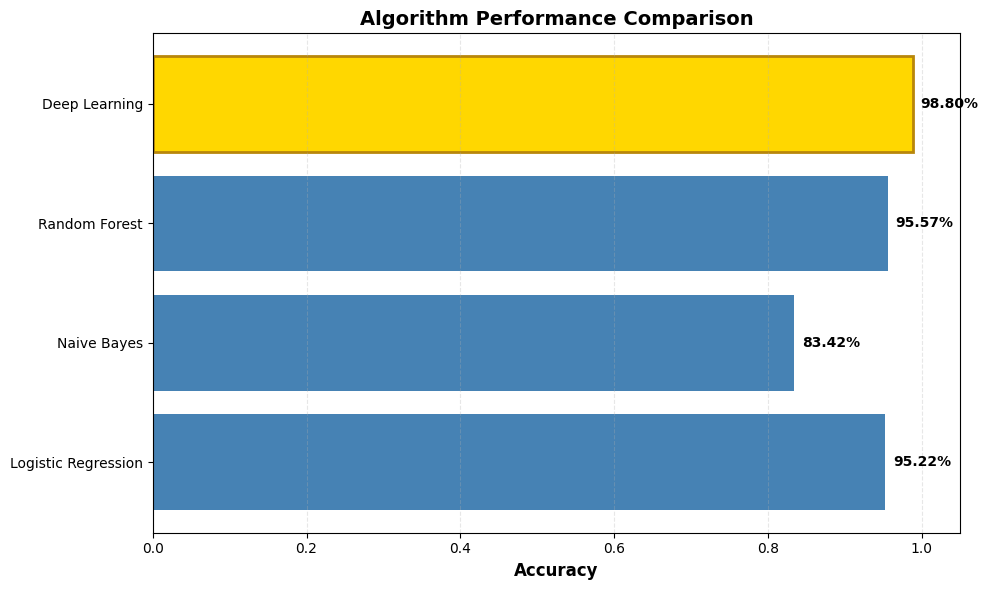


All Model Results:
| Deep Learning: Acc=98.80%, F1=98.80%, Prec=98.81%, Rec=98.80%
   Random Forest: Acc=95.57%, F1=95.57%, Prec=95.57%, Rec=95.57%
   Logistic Regression: Acc=95.22%, F1=95.20%, Prec=95.39%, Rec=95.22%
   Naive Bayes: Acc=83.42%, F1=83.44%, Prec=83.50%, Rec=83.42%


In [ ]:
print("STARTING MODEL COMPARISON...")
results = {}  # Will store all metrics for each model
trained_models = {}

# --- A. TRADITIONAL ML (Uses TF-IDF) ---
print("\n[1/2] Training Traditional ML Models...")
print("Vectorizing text (TF-IDF)...")

# Reduced max_features for faster processing
tfidf = TfidfVectorizer(
    stop_words='english',
    max_features=10000,  # 10000
    min_df=2,  # Ignore terms that appear in less than 2 documents
    max_df=0.95  # Ignore terms that appear in more than 95% of documents
)

X_tfidf = tfidf.fit_transform(train_df['text'])
print(f"TF-IDF vectorization complete. Shape: {X_tfidf.shape}")

X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(
    X_tfidf, y_all, test_size=0.2, random_state=42, stratify=y_all
)

ml_algorithms = {
    "Logistic Regression": LogisticRegression(max_iter=1000, n_jobs=-1),  # Faster
    "Naive Bayes": MultinomialNB(),  # Fast
    "Random Forest": RandomForestClassifier(n_estimators=50, n_jobs=-1),  # Reduced from 100
}

for name, model in ml_algorithms.items():
    print(f"\nTraining {name}...", end=" ")
    model.fit(X_train_ml, y_train_ml)
    y_pred = model.predict(X_test_ml)

    # Calculate all metrics
    acc = accuracy_score(y_test_ml, y_pred)
    f1 = f1_score(y_test_ml, y_pred, average='weighted')
    precision = precision_score(y_test_ml, y_pred, average='weighted')
    recall = recall_score(y_test_ml, y_pred, average='weighted')

    results[name] = {
        'accuracy': acc,
        'f1_score': f1,
        'precision': precision,
        'recall': recall
    }
    trained_models[name] = model
    print(f"Acc: {acc:.2%} | F1: {f1:.2%} | Prec: {precision:.2%} | Rec: {recall:.2%}")

# B. DEEP LEARNING (Uses LSTM)
print("\n[2/2] Training Deep Learning (LSTM)...")
vocab_size = 10000
max_length = 100
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['text'])

X_seq = tokenizer.texts_to_sequences(train_df['text'])
X_pad = pad_sequences(X_seq, maxlen=max_length, padding='post')
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(
    X_pad, y_all, test_size=0.2, random_state=42, stratify=y_all
)

dl_model = Sequential([
    Embedding(vocab_size, 64, input_length=max_length),
    Bidirectional(LSTM(64)),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
dl_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train with progress bar
history = dl_model.fit(
    X_train_dl, y_train_dl,
    epochs=5,
    validation_data=(X_test_dl, y_test_dl),
    verbose=1,  # Show progress
    batch_size=32
)

# Evaluate and calculate all metrics
y_pred_dl = (dl_model.predict(X_test_dl, verbose=0) > 0.5).astype(int).flatten()
acc_dl = accuracy_score(y_test_dl, y_pred_dl)
f1_dl = f1_score(y_test_dl, y_pred_dl, average='weighted')
precision_dl = precision_score(y_test_dl, y_pred_dl, average='weighted')
recall_dl = recall_score(y_test_dl, y_pred_dl, average='weighted')

results['Deep Learning'] = {
    'accuracy': acc_dl,
    'f1_score': f1_dl,
    'precision': precision_dl,
    'recall': recall_dl
}
trained_models['Deep Learning'] = dl_model
print(f"Acc: {acc_dl:.2%} | F1: {f1_dl:.2%} | Prec: {precision_dl:.2%} | Rec: {recall_dl:.2%}")

# --- C. DECLARE WINNER ---
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
print(f"\nWINNER: {best_model_name} (Accuracy: {results[best_model_name]['accuracy']:.2%})")

# Visualize Model Comparison
plt.figure(figsize=(10, 6))
models = list(results.keys())
# Extract accuracy values from the results dictionaries
accuracies = [results[m]['accuracy'] for m in models]

# Create bar plot
bars = plt.barh(models, accuracies, color=['gold' if m == best_model_name else 'steelblue' for m in models])

# Add accuracy labels on bars
for i, (model, acc) in enumerate(zip(models, accuracies)):
    plt.text(acc + 0.01, i, f'{acc:.2%}', va='center', fontweight='bold')

# Highlight winner
winner_idx = models.index(best_model_name)
bars[winner_idx].set_color('gold')
bars[winner_idx].set_edgecolor('darkgoldenrod')
bars[winner_idx].set_linewidth(2)

plt.xlabel('Accuracy', fontsize=12, fontweight='bold')
plt.title('Algorithm Performance Comparison', fontsize=14, fontweight='bold')
plt.xlim(0, 1.05)
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print(f"\nAll Model Results:")
for model, metrics in sorted(results.items(), key=lambda x: x[1]['accuracy'], reverse=True):
    status = "|" if model == best_model_name else "  "
    print(f"{status} {model}: Acc={metrics['accuracy']:.2%}, F1={metrics['f1_score']:.2%}, Prec={metrics['precision']:.2%}, Rec={metrics['recall']:.2%}")

# Helper function to predict using the WINNER
def predict_unknown(text):
    text_clean = [str(text)[:500]]  # Limit length

    if best_model_name == 'Deep Learning':
        # Use Tokenizer Pipeline
        seq = tokenizer.texts_to_sequences(text_clean)
        pad = pad_sequences(seq, maxlen=max_length, padding='post')
        prob = trained_models['Deep Learning'].predict(pad, verbose=0)[0][0]
    else:
        # Use TF-IDF Pipeline
        vec = tfidf.transform(text_clean)
        prob = trained_models[best_model_name].predict_proba(vec)[0][1] # Probability of Class 1 (Halal)

    label = "HALAL" if prob > 0.5 else "DOUBTFUL"
    return label, prob

In [ ]:
def check_ingredient_status(text):
    print(f"\nAnalyzing Product: '{text[:100]}...'")
    print("-" * 60)

    # 1. SPLIT INPUT
    ingredients = re.split(r',|\band\b', text)
    ingredients = [i.strip() for i in ingredients if i.strip()]

    overall_status = "HALAL"
    flagged_items = []
    safe_items = []

    # 2. ANALYZE
    for item in ingredients:
        item_status = "UNKNOWN"
        source = f"AI ({best_model_name})"

        # A. DB CHECK
        db_match = False
        for code, status in knowledge_base.items():
            if code.isdigit():
                 pattern = r'(?<!\d)(e-?)?' + re.escape(code) + r'(?!\d)'
            else:
                 pattern = r'(^|[^a-z0-9])' + re.escape(code) + r'($|[^a-z0-9])'

            if re.search(pattern, item.lower()):
                item_status = status.upper()
                source = "DB"
                db_match = True
                break

        # B. AI CHECK (Using the Winner)
        if not db_match:
            pred_label, pred_prob = predict_unknown(item)
            item_status = pred_label
            print(f"{item}: {pred_label} ({pred_prob:.0%})")

        # C. RECORD
        if "DOUBTFUL" in item_status or "HARAM" in item_status:
            overall_status = "DOUBTFUL"
            flagged_items.append(f"🔴 {item} ({source}: {item_status})")
        else:
            safe_items.append(f"🟢 {item} ({source}: {item_status})")

    # 3. REPORT
    if overall_status == "DOUBTFUL":
        print(f"FINAL VERDICT: DOUBTFUL / HARAM")
        print("Reason: The following ingredients were flagged:")
        for i in flagged_items: print(f"   {i}")
        if safe_items:
            print(f"(Safe items: {', '.join([x.split('(')[0].strip()[2:] for x in safe_items])})")
    else:
        print(f"FINAL VERDICT: HALAL")
        print("All ingredients appear safe.")

In [ ]:
# Testing manually insert ingredients
print(check_ingredient_status("noodles (wheat flour, refined palm oil, salt, and acidity regulators), seasoning powder (salt, sugar, flavor enhancers, onion, garlic, artificial chicken flavor), seasoning oil (refined palm oil, shallot), sweet soy sauce (sugar, water, wheat, soybean, spices, sesame oil), and chili powder."))


Analyzing Product: 'noodles (wheat flour, refined palm oil, salt, and acidity regulators), seasoning powder (salt, sugar...'
------------------------------------------------------------
noodles (wheat flour: HALAL (100%)
refined palm oil: HALAL (100%)
salt: HALAL (100%)
acidity regulators): HALAL (100%)
seasoning powder (salt: HALAL (100%)
sugar: HALAL (100%)
flavor enhancers: HALAL (100%)
onion: HALAL (100%)
garlic: HALAL (100%)
artificial chicken flavor): HALAL (100%)
seasoning oil (refined palm oil: HALAL (100%)
shallot): HALAL (100%)
sweet soy sauce (sugar: DOUBTFUL (37%)
water: HALAL (100%)
wheat: HALAL (100%)
soybean: HALAL (100%)
spices: HALAL (100%)
sesame oil): HALAL (100%)
chili powder.: HALAL (100%)
FINAL VERDICT: DOUBTFUL / HARAM
Reason: The following ingredients were flagged:
   🔴 sweet soy sauce (sugar (AI (Deep Learning): DOUBTFUL)
(Safe items: noodles, refined palm oil, salt, acidity regulators), seasoning powder, sugar, flavor enhancers, onion, garlic, artificial chic

In [ ]:
# 4. Install the OCR engine (Tesseract) and Python library
!sudo apt install tesseract-ocr
!pip install pytesseract

import os
import pytesseract
from PIL import Image
import requests
from io import BytesIO

pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

def analyze_image(image_path_or_url, is_url=False):
    try:
        if is_url:
            response = requests.get(image_path_or_url)
            img = Image.open(BytesIO(response.content))
        else:
            img = Image.open(image_path_or_url)

        plt.figure(figsize=(6, 3))
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        print("Reading text from image...")
        custom_config = r'--oem 3 --psm 6'
        extracted_text = pytesseract.image_to_string(img, config=custom_config)
        cleaned_text = extracted_text.replace('\n', ', ').replace('|', '')

        print(f"Extracted: '{cleaned_text[:100]}...'")
        check_ingredient_status(cleaned_text)

    except Exception as e:
        print(f"Error: {e}")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.



📤 Upload an image of an ingredient label:


Saving WhatsApp Image 2026-01-10 at 7.55.16 PM.jpeg to WhatsApp Image 2026-01-10 at 7.55.16 PM (2).jpeg


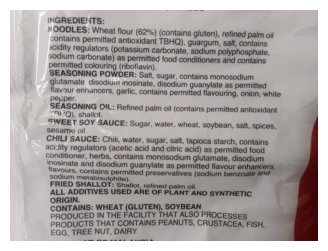

Reading text from image...
Extracted: 'INGREDIENTS:, , N OODLES: Wheat flour (62%) (contains gluten), refined palm oil, contains permitted ...'

Analyzing Product: 'INGREDIENTS:, , N OODLES: Wheat flour (62%) (contains gluten), refined palm oil, contains permitted ...'
------------------------------------------------------------
FINAL VERDICT: DOUBTFUL / HARAM
Reason: The following ingredients were flagged:
   🔴 contains permitted antioxidant TBHQ) (DB: DOUBTFUL)
   🔴 disodium guanylate as permitted (DB: DOUBTFUL)
   🔴 SWEET SOY SAUCE: Sugar (AI (Deep Learning): DOUBTFUL (63.0% Confidence))
   🔴 acidity regulators (acetic acid (DB: DOUBTFUL)
   🔴 citric acid) as permitted food (DB: DOUBTFUL)
   🔴 contains monosodium glutamate (DB: DOUBTFUL)
   🔴 disodium guanylate as permitted flavour (DB: DOUBTFUL)
(Safe items: INGREDIENTS:, N OODLES: Wheat flour, refined palm oil, guargum, salt, contains, acidity regulators, sodium polyphosphate, sodium carbonate) as permitted food conditioners, cont

In [ ]:
import pytesseract
from PIL import Image
import requests
from io import BytesIO

pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

def analyze_image(image_path_or_url, is_url=False):
    try:
        if is_url:
            response = requests.get(image_path_or_url)
            img = Image.open(BytesIO(response.content))
        else:
            img = Image.open(image_path_or_url)

        plt.figure(figsize=(6, 3))
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        print("Reading text from image...")
        custom_config = r'--oem 3 --psm 6'
        extracted_text = pytesseract.image_to_string(img, config=custom_config)
        cleaned_text = extracted_text.replace('\n', ', ').replace('|', '')

        print(f"Extracted: '{cleaned_text[:100]}...'")
        check_ingredient_status(cleaned_text)

    except Exception as e:
        print(f"Error: {e}")

# 5. TEST
from google.colab import files

def upload_and_analyze():
    print("\n📤 Upload an image of an ingredient label:")
    uploaded = files.upload()
    for filename in uploaded.keys():
        analyze_image(filename, is_url=False)

upload_and_analyze()